# Examen 2
## Cours A59 - apprentissage par renforcement
## 
-----


**Objectif**

Nous allons utiliser un réseau DQN mais sur un environnement déjà résolu avec des algorithmes classiques.<br>

C'est l'opportunité de tester quelques hypothèses sans pénaliser ceux d'entre vous qui ont des machines moins puissantes.<br>

Vous aurez besoin des bibliothèques suivantes :<br>
 Python 3.11<br>
 tensorflow 2.17<br>
 gymnasium <= 1.0<br>
 numpy<br>
 matplotlib<br>

Deux fichiers sont diponibles pour installer des environnements virtuels compatibles (requirementsxx.txt).

Les documents sont autorisés.<br>
Il s'agit d'un travail personnel.<br>

La durée est de 2h30.<br>

Le total fait 25 points.<br>
Décomposition :<br>
Compréhension de l'environnement (3 pts)<br>
Réseaux de neurones (4 pts)<br>
DQN variantes(3 pts)<br>
Fonction de représentation de l'état (3 pts)<br>
Exécution et vérification (4 pts)<br>
DQN vs Q Learning (3 pts)<br>
DQN vs Policy gradient (5pts)<br>

### Une fois terminé, merci de m'envoyer le notebook renommé avec votre prénom nom avant l'heure limite.<br>

(c) Fabrice Mulotti


<div class="alert alert-block alert-warning">
<b>A faire</b> <br>
Vous devez compléter là ou est inscrit<br>
    #VOTRE RESPONSE ou <br>
    #VOTRE CODE
</div>

In [1]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import numpy as np
import gymnasium as gym
from collections import deque
import random
import matplotlib.pyplot as plt
import tensorflow as tf

print(f"TensorFlow version {tf.__version__}")
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam 

import time
# si vous utilisez keras 2.x, décommentez
# tf.compat.v1.disable_eager_execution()


2024-11-04 19:47:33.415199: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730767653.456895 3075970 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730767653.469138 3075970 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-04 19:47:33.505251: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version 2.18.0


---
## Définition de l'environnement

Lien vers les informations sur l'environnement : __[Frozen lake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/)__


In [3]:
ENV_NAME = "FrozenLake-v1"

env = gym.make(ENV_NAME,is_slippery=False)
np.random.seed(100)
env.reset(seed=100)
nb_actions = env.action_space.n # Nombre d'action
nb_obs = env.observation_space.n # nombre de position dans notre environnement
print(f"Nombre d actions : {nb_actions}, Dimension de l env : {nb_obs}")

Nombre d actions : 4, Dimension de l env : 16


### Remarques sur l'environnement

4 actions possibles :<br>
    Gauche, bas, droite, haut
    
Observation :<br>
    Valeurs discrètes (0 à 15)

## Compréhension de l'environnement (3 pts)
 la suite du TP il va être important de bien comprendre le principe des récompenses.

La transition vers **l'objectif** rapporte combien ?

La transition vers **un puit** rapporte combien ?

La transition vers une **case gelée** (c'est à dire toutes les autres cases) rapporte combien ?

Donc un épisode avec echec aura une récompense **totale** (G avec gamma=1) de combien ?

Et donc un épisode réussi aura une récompense **totale** (G avec gamma=1) de combien ?

Quelles sont donc les deux seules récompenses possibles cumulées pour un épisode ?

---
## Représentation de l'environnement

Nous sommes sur une matrice 4x4.

Il existe plusieurs facons de représentation chaque état.

Cela pourrait être par exemple, une seule valeur d'entrée, un entier entre 0 et 15.

Nous allons opter pour une approche qui montre plus d'efficacité, nous allons représenter le statut par un numpy de 1 dimension de grandeur 16.
Toutes les valeurs seront à zéro, sauf l'indice correspondant à la position du joueur qui sera à 1.

Exemple :
Si nous déclarerions un tableau numpy S tel que S=np.zeros((16))
Alors si le joueur est en position 3 => S[3]=1 

S = [ 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 ]

---
## Réseau de neurones ( 4 pts)


Pouvez vous donner une proposition de description pour ce réseaux en **expliquant pourquoi** :
- nombre de neurones pour les couches d'entrée, cachée(s) et de sortie<br>
- type de couche<br>

Il y a plusieurs réponses possibles.

## Fonctions utiles (rien à coder ici)

In [4]:
# Classe pour notre algorithme DQN
class DQN:
    def __init__(self, obs_size, action_size, gamma, learning_rate,layer1=16):
        # Objet : initialisation de la classe
        # Paramètres en entrée
        #     Nombre de paramètres pour décrire l'état
        #     Nombre d'actions
        #.    Paramètre gamma : dépréciation futur
        #     learning rate
        
        # dimension des états
        self.obs_size = obs_size
        
        # nombre d'actions
        self.action_size = action_size
        
        # gamma : dépréciation du futur
        self.gamma = gamma
        
        # learning rate
        self.learning_rate = learning_rate
        
        # autres paramètres
        self.update_freq = 100 # fréquence de copie des poids (1000)
        
        # autres structures
        self.replay_buffer = deque(maxlen=5000) # enregistrements des résultats
        
        # Modèle de réseaux de neurones
        self.main_network = self.build_model(layer1)
        self.target_network = self.build_model(layer1)
        
        # recopie des poids pour avoir des réseaux à l'identique
        self.target_network.set_weights(self.main_network.get_weights())
        
              
    def build_model(self,layer1):
        # input : size of the 2 layers
        # output : model of neural network
        model = Sequential()
        model.add(Dense(layer1,input_shape=(self.obs_size,),activation='relu'))
        model.add(Dense(self.action_size))
        model.add(Activation('linear'))
        # si keras 2.x
        # model.compile(loss='mse',optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=self.learning_rate))
        # si keras 3.x
        model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),jit_compile=True)

        return model

    def store_transition(self,state,action,reward,next_state,done):
        # input : 
        # output : nothing
        self.replay_buffer.append((state,action,reward,next_state,done))
        
    def policy(self, state, epsilon):
        # Policy : return action regarding the state according to the policy
        r = np.random.uniform()
        if r < epsilon:
            action = np.random.randint(self.action_size)
        else:
            actions = self.main_network.predict_on_batch(state)
            action = np.argmax(actions[0])
 
        return action

    @tf.function
    def _train_step(self, states, Q_values):    
            self.main_network.fit(states,Q_values,epochs=1,verbose=0)
        
    def train_model_fast(self,batch_size):
         # Implémentation parallèle
        minibatch = random.sample(self.replay_buffer,batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        # on supprime l'axe y (=1) de x,y,z
        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        # 1-done : si done on ne prend en compte que reward
        targets = rewards + self.gamma*(np.amax(self.target_network.predict_on_batch(next_states), axis=1))*(1-dones) 
        
        targets_full = self.target_network.predict_on_batch(states) 
        ind = np.array([i for i in range(batch_size)])
        targets_full[[ind], [actions]] = targets      
        
        #self.main_network.fit(states, targets_full, epochs=1, verbose=0)
        self._train_step(states,targets_full)
        
    def update_weights(self):
        self.target_network.set_weights(self.main_network.get_weights())
    

---

## Variante DQN (3 pts)

Pouvez vous décrire une variante de DQN et son intêret en quelques mots ? 

---

# Représentation de l'état (3 pts)

In [5]:
# transformation des données pour compatabilité avec l'alimentation du réseau de neurones (1,s)`
def trans_state(s):
    # VOTRE CODE 3 pts
    # en entrée nous avons un entier compris en 0 et 15 (bornes incluses)
    # en sortie un numpy de dimension [ 1 , nombre obervation ] 
    # Le tableau aura la valeur zéro (0) à toutes les positions sauf pour l'indice correspondant à s ou nous souhaitons la valeur un (1)
    arr = np.zeros((1, 16))
    arr[0,s] =1
    return arr

In [6]:
x = trans_state(5)

In [7]:
# ne devrait pas générer d'erreur
assert (trans_state(5) == np.array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])).all() == True

----
## Lancons la simulation
Réussite et vérification : 4 pts

In [8]:
num_episodes = 1000
batch_size = 10 # K
gamma=0.99 

# variation du epsilon de notre politique e-greedy
epsilon_max=1.00
epsilon_min=0.10
epsilon_decay=(epsilon_max-epsilon_min)/(num_episodes/2)

learning_rate=0.001 # 0.001

In [9]:
dqn = DQN(nb_obs,nb_actions,gamma,learning_rate,64)

/home/renato/PythonVenvs/venv_py12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-04 19:47:49.580821: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [10]:
start_time=time.time()
last_time=start_time
train_time=0
time_step = 0  # comptage du nombre total de mouvement
histoReturn=[] # pour graphique sur historique récompense
epsilon=epsilon_max

for i in range(num_episodes):
    # somme de la récompense total pour une cycle
    Return = 0
    
    # reset env et conversion state
    state = trans_state(env.reset()[0])
    done=False
    truncated=False
    episode_length=0
    while not(done or truncated):
    
        time_step += 1
        episode_length+=1

        # copie des poids du réseau d'entrainement vers le réseau cible selon la fréquence choisie
        if time_step % dqn.update_freq == 0:
            dqn.update_weights()
        
        # sélection d'une action selon notre politique
        action = dqn.policy(state,epsilon)

        # jouer l'action
        next_state, reward, done, truncated , _ = env.step(action)
        next_state=trans_state(next_state) # reformatage
        if truncated:
            done=True 
      
        # enregistrement pour replay
        dqn.store_transition(state, action, reward, next_state, done)
        
        # et shift d'état
        state = next_state
        
        # cumul du retour G
        Return += reward

        if episode_length==100: # nous limitons les épisodes à 100 mouvements
            truncated=True
            
        # Done ?
        if done or truncated:    
            # on décremmente epsilon
            epsilon -= epsilon_decay
            epsilon = max(epsilon_min, epsilon)
            histoReturn.append(Return)

            # affichage du résultat du cyle
            if (i>0 and i % 100 ==0) or i == (num_episodes-1):
                print(f"Episode {i}, Taux de victoire {np.round(np.sum(histoReturn)/(i+1)*100,0)}%,\
                 epsilon {np.round(epsilon,2)}, durée {int(time.time()-last_time)}, training time {int(train_time)}")
                last_time=time.time()
                train_time=0
            break
            
        # à partir de + batch-size on entraine le reseau
        train_start=time.time()
        if len(dqn.replay_buffer) > batch_size: #  and i%10 == 0:
            dqn.train_model_fast(batch_size)
        train_end=time.time()
        train_time += train_end-train_start
print("--------------------------------------------------")
print(f"Durée de l'entrainement = {np.round(time.time()-start_time,0)} secondes")

I0000 00:00:1730767669.892803 3075995 service.cc:148] XLA service 0x726028006970 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730767669.892858 3075995 service.cc:156]   StreamExecutor device (0): Host, Default Version
2024-11-04 19:47:49.911430: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1730767670.010234 3075995 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Episode 100, Taux de victoire 6.0%,                 epsilon 0.82, durée 29, training time 28
Episode 200, Taux de victoire 9.0%,                 epsilon 0.64, durée 29, training time 28
Episode 300, Taux de victoire 17.0%,                 epsilon 0.46, durée 24, training time 24
Episode 400, Taux de victoire 29.0%,                 epsilon 0.28, durée 24, training time 23
Episode 500, Taux de victoire 41.0%,                 epsilon 0.1, durée 23, training time 22
Episode 600, Taux de victoire 48.0%,                 epsilon 0.1, durée 21, training time 20
Episode 700, Taux de victoire 54.0%,                 epsilon 0.1, durée 20, training time 19
Episode 800, Taux de victoire 58.0%,                 epsilon 0.1, durée 20, training time 19
Episode 900, Taux de victoire 62.0%,                 epsilon 0.1, durée 20, training time 19
Episode 999, Taux de victoire 65.0%,                 epsilon 0.1, durée 22, training time 21
--------------------------------------------------
Durée de l'entrai

Vous devriez arriver à un taux de réussite de près de 60% à la fin de l'entrainement.

Si réussite 2 pts

---

Que recommande notre classe dqn en position 0 et 14 ? ( 1pts)

In [11]:
state_0 = trans_state(0)
state_14 = trans_state(14)

print(dqn.policy(state_0, 0))
print(dqn.policy(state_14, 0))

1
2


Est ce correct ? (1 pts)

---
# Comparons avec Q-Learning Classique (rien à coder)

In [12]:
def politique_egreedy(env,Q,s,epsilon):
    # en entrée : env=environnement, Q fonctions action valeur, s = état courant, epsilon= pour espilon-greedy
    r=np.random.uniform()
    if r<epsilon:
        return(env.action_space.sample())
    else:
        return(np.argmax(Q[s,]))

In [13]:
# Nombre d'essai
max_iter=50000
alpha=0.50   # learning rate
gamma=0.99   # part du futur
epsilon=1.0 # part de hasard
epsilon_min=0.10
epsilon_decay=(epsilon-epsilon_min)/(max_iter/2)
Q=np.zeros((env.observation_space.n,env.action_space.n))

# liste des valeurs pour créer un graphique 
histoReturn=[]
histoLongueurEpisode=[]
start_time=time.time()
for i in range(max_iter):
    S=env.reset()[0]

    done=False
    truncated=False
    cumulR=0 # cumul des récompenses par épisode
    cumulA=0 # cumul du nombre d'action = longueur des épisodes
    
    while not (done or truncated):
        A=politique_egreedy(env,Q,S,epsilon)
        S_ , R, done, truncated, _ = env.step(A)
        A_=politique_egreedy(env,Q,S_,0) # ## epsilon = 0 => pas de hasard = greedy
        
        Q[S,A] = Q[S,A] + alpha*(R+gamma*Q[S_,A_]-Q[S,A])

        cumulR+=R
        cumulA+=1
        S=S_

    epsilon -= epsilon_decay
    epsilon = max(epsilon, epsilon_min)
    
    histoReturn.append(cumulR)
    histoLongueurEpisode.append(cumulA)
 
    if i % (max_iter/10) ==0 or i == (max_iter-1):
      print(f"Episode {i}, Taux de victoire {np.round(np.sum(histoReturn)/(i+1)*100,0)}%,\
      epsilon {np.round(epsilon,2)}")

print(f"Durée de l'entrainement = {np.round(time.time()-start_time,0)} secondes")

Episode 0, Taux de victoire 0.0%,      epsilon 1.0
Episode 5000, Taux de victoire 4.0%,      epsilon 0.82
Episode 10000, Taux de victoire 10.0%,      epsilon 0.64
Episode 15000, Taux de victoire 18.0%,      epsilon 0.46
Episode 20000, Taux de victoire 28.0%,      epsilon 0.28
Episode 25000, Taux de victoire 38.0%,      epsilon 0.1
Episode 30000, Taux de victoire 47.0%,      epsilon 0.1
Episode 35000, Taux de victoire 53.0%,      epsilon 0.1
Episode 40000, Taux de victoire 57.0%,      epsilon 0.1
Episode 45000, Taux de victoire 61.0%,      epsilon 0.1
Episode 49999, Taux de victoire 64.0%,      epsilon 0.1
Durée de l'entrainement = 29.0 secondes


Vous devriez arriver à un taux autour de 60%

/tmp/ipykernel_3075970/156184330.py:9: RuntimeWarning: invalid value encountered in divide
  ax1.plot(np.cumsum(histoReturn)/np.arange(max_iter)*100)
/tmp/ipykernel_3075970/156184330.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


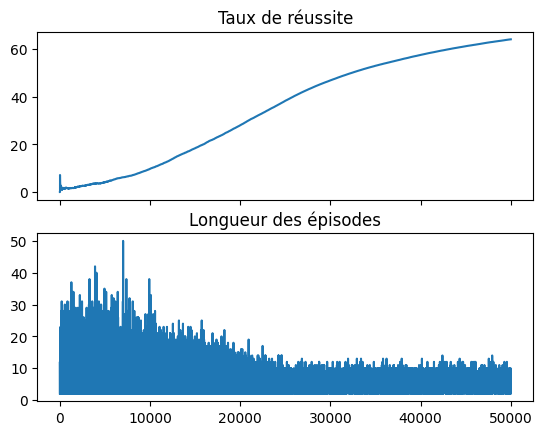

In [14]:
fig,(ax1,ax2)=plt.subplots(2,1,sharex=True)

ax1.set_title("Taux de réussite")
ax2.set_title("Longueur des épisodes")

# fig.title("Récompenses cumulées par épisode")

ax2.plot(histoLongueurEpisode)
ax1.plot(np.cumsum(histoReturn)/np.arange(max_iter)*100)
fig.show()

---
# Comparaison (3 pts)

Nous venons de tester un algortihme avec réseau de neurones et un algoritgme classique.

En comparant le temps de traitement, puis le nombre de d'épisode nécessaire, quelles conclusions pouvez vous tirer ?

---
## DQN vs Policy Gradient ( 5pts)

Aurions nous pu utiliser policy gradient pour résoudre cet environnement ?


In [ ]:
%md
# VOTRE REPONSE
Oui, le policy gradient peut être utilisé autant pour des environnements discrets que continues

Citer 3 différences entre les deux implémentations (DQN vs Policy Gradient) ?

In [ ]:
# VOTRE REPONSE
Policy gradient: n'a pas une q-table avec des actions définies, mais une distributions 
de probabilités des actions possibles

Policy gradient: adéquats pour des environnements continues (alors q DQN est déterministique: un état, une action)

Policy gradient: dans le cas du frozen lake, je suppose qu'il convergirait plus vite que DQN à la solution optimale 
car il n'a pas besoin de replays. 
Policy gradient est algorithmiquement moins complexe que DQN (moins d'opérations à faire)

---
# N'oubliez pas de m'envoyer le notebook par MIO !